<h2> Importing essential libraries </h2>

In [1]:
# Import essential libraries
import tensorflow  as tf
import keras
from keras import layers
from keras import models


import numpy as np
import time as tm
import matplotlib.pyplot as plt

import tensorboard as tb

D:\DataScience\IDE\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.10.0'

In [3]:
import image_loader

import models
import config_file as config

(10, 1)


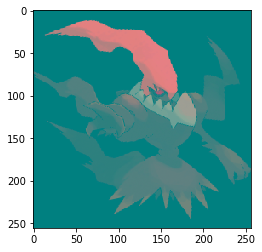

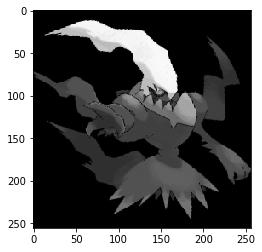

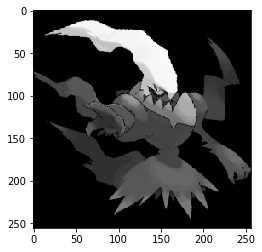

(10, 256, 256, 3)
(10, 256, 256, 1)
(10,)
(10, 1)
(10, 1)


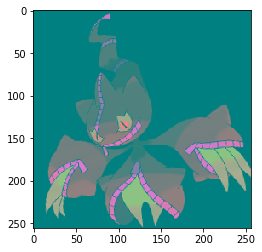

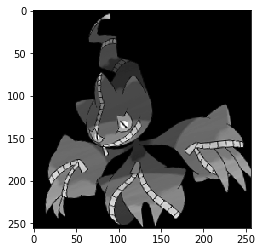

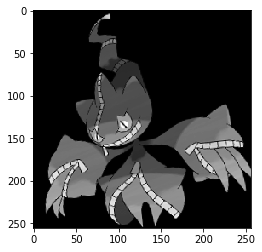

(10, 256, 256, 3)
(10, 256, 256, 1)
(10,)
(10, 1)


In [4]:
# Dataset generator debugger

debugging = True
if debugging:
    DBG = image_loader.DataBatchGenerator()

    batch = DBG.get_train_data_batch(batch_size=10)
    print(batch['labels'].shape)
    indices, lab_batch, gray_batch, labels = batch['index'], batch['lab_batch'], batch['gray_batch'].reshape([-1,256,256,1]), batch['labels']

    plt.imshow(lab_batch[5])
    plt.show()
    
    plt.imshow(gray_batch[5].reshape([256, 256]), cmap='gray')
    plt.show()
    
    plt.imshow(lab_batch[5][:,:,0], cmap='gray')
    plt.show()
    
    print(lab_batch.shape)
    print(gray_batch.shape)
    print(indices.shape)
    print(labels.shape)
    
    batch = DBG.get_test_data_batch(batch_size=10)
    print(batch['labels'].shape)
    indices, lab_batch, gray_batch, labels = batch['index'], batch['lab_batch'], batch['gray_batch'].reshape([-1,256,256,1]), batch['labels']

    plt.imshow(lab_batch[5])
    plt.show()
    
    plt.imshow(gray_batch[5].reshape([256, 256]), cmap='gray')
    plt.show()
    
    plt.imshow(lab_batch[5][:,:,0], cmap='gray')
    plt.show()
    
    print(lab_batch.shape)
    print(gray_batch.shape)
    print(indices.shape)
    print(labels.shape)
    
    
    


def display_parameters():
    print(graphs)
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        print(shape)
        print(len(shape))
        variable_parameters = 1
        for dim in shape:
            print(dim)
            variable_parameters *= dim.value
        print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters*4)

<h2> Training module </h2>

<h3> Training parameters </h3>

In [5]:
# Training parameters
num_epochs = 1
using_saved_model = False       # If checked enter model chkpt name in promt and corresponding model will be used
save_model = True

# -- Parameters for labels optimizer
alpha = 0.5
labels_learning_rate = 0.001 * alpha # 0.5 is alpha in formula

# -- Parameters for outputs optimizer
outputs_learning_rate = 0.001

# Dataset batch generator
DBG = image_loader.DataBatchGenerator()

<h3> This is the tf <i><b>graph model</b></i> for colorization </h3>

In [6]:
# Building out the model
#######################################################################################
# Pre-setting model
colorization_network = models.ColorizationNetwork(config.NUM_LABELS)

# Pre-setting inputs

# -- For image coloring
gray_inputs = tf.placeholder(dtype=tf.float32, shape=[None,256,256,1], name='gray_inputs')
lab_inputs = tf.placeholder(dtype=tf.float32, shape=[None,256,256,3], name='lab_inputs')

# -- For image labels
label_inputs = tf.placeholder(dtype=tf.float32, shape=[None, config.NUM_LABELS], name='label_inputs')

# Setting out losses and optimizers

# -- For image outputs
outputs_loss_fn = tf.losses.mean_squared_error
outputs_optimizer = tf.train.AdamOptimizer(learning_rate=outputs_learning_rate)

# -- For image labels
labels_loss_fn = tf.losses.softmax_cross_entropy
labels_optimizer = tf.train.AdamOptimizer(learning_rate=labels_learning_rate)   

# Creating model:
img_outputs, img_labels = colorization_network.forward(inputs=gray_inputs)

# Buiilding graph for output image
outputs_scaled = img_outputs*255.0 # Rescaling back to pixel values
loss_outputs=outputs_loss_fn(lab_inputs[:,:,:,1:], outputs_scaled)
train_outputs = outputs_optimizer.minimize(loss_outputs)

# Building graph for output labels
loss_labels = labels_loss_fn(label_inputs, img_labels)
train_labels = labels_optimizer.minimize(loss_labels)

# -- Reqd tensor board operations --
with tf.name_scope('loss'):
    tf.summary.scalar('output_loss', loss_outputs)
    tf.summary.scalar('label_loss', loss_labels)
    merged = tf.summary.merge_all()
#########################################################################################

In [7]:
# Model saver and checkpoint names (with path)
saver = tf.train.Saver()
session_name = './models/model-checkpoint.ckpt'

train_output_loss_vector_name = './models/outputs-loss-train.npy'
train_label_loss_vector_name = './models/labels-loss-train.npy'
test_output_loss_vector_name = './models/outputs-loss-train.npy'
test_label_loss_vector_name = './models/labels-loss-train.npy'

# Saving and loading sessions and losses 
if using_saved_model:
    
    sess = tf.Session()
    saver.restore(sess, session_name)
    
    test_output_losses = np.load(test_output_loss_vector_name).tolist()
    test_label_losses = np.load(test_label_loss_vector_name).tolist()
    train_output_losses = np.load(train_output_loss_vector_name).tolist()
    train_label_losses = np.load(train_label_loss_vector_name).tolist()
    
# Creating sessions if required and losses
else:
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    test_output_losses = []
    test_label_losses = []
    train_output_losses = []
    train_label_losses = []
    
# -- tensorboard operations -- 
logs_path = './logs_dir/'
summary_writer = tf.summary.FileWriter(logs_path, sess.graph)

<h3> Training module and loop </h3>

In [8]:
# Training module function
for epoch in range(1, num_epochs+1):
    print("####################################\n############  Epoch : {} ############".format(epoch))
    start_time = tm.time()
    #---------------------------------------------------------------------------------------------------------------------
    # ---------------    TRAINING MODULE    ---------------------------
    # Getting the batch for training
    batch = DBG.get_train_data_batch()
    print()
    lab_batch, gray_batch, labels = batch['lab_batch'], batch['gray_batch'].reshape([-1,256,256,1]), batch['labels']
    gray_batch = gray_batch.reshape([config.BATCH_SIZE, 256, 256, 1])
    
    # Computing labels
    computed_label_loss = sess.run(
        (loss_labels, train_labels),
        feed_dict={gray_inputs:gray_batch, lab_inputs:lab_batch, label_inputs:labels}
    )
    
    # Computing outputs
    computed_output_loss = sess.run(
        (loss_outputs, train_outputs), 
        feed_dict={gray_inputs:gray_batch, lab_inputs:lab_batch, label_inputs:labels}
    )
    # ---------------------  STORING LOSSES-TRAINING  -----------------
    train_output_losses.append(computed_output_loss[0])
    train_label_losses.append(computed_label_loss[0])
    # ----------------    TESTING MODULE    ---------------------------
    # Getting the batch for testing
    batch = DBG.get_test_data_batch()
    lab_batch, gray_batch, labels = batch['lab_batch'], batch['gray_batch'].reshape([-1,256,256,1]), batch['labels']
    gray_batch = gray_batch.reshape([config.BATCH_SIZE, 256, 256, 1])
    
    # Computing labels
    computed_label_loss = sess.run(
        loss_labels,
        feed_dict={gray_inputs:gray_batch, lab_inputs:lab_batch, label_inputs:labels}
    )
    
    # Computing outputs
    computed_output_loss = sess.run(
        loss_outputs,
        feed_dict={gray_inputs:gray_batch, lab_inputs:lab_batch, label_inputs:labels}
    )
    
    # ----------------------  STORING LOSSES-TESTING  -----------------
    test_output_losses.append(computed_output_loss)
    test_label_losses.append(computed_label_loss)
    # --------------------------------------------------------------------------------------------------------------------
    # ------- EVALUATE RESULTS TO PREVENT OVERFITTING ------------------
    if epoch%10 == 0:
        # Show losses for training
        print("Display output loss graph - TRAIN:")
        plt.plot(train_output_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Output loss')
        plt.title("Output loss in epochs ")
        plt.show()

        print("Display label loss graph - TRAIN:")
        plt.plot(train_label_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Output loss')
        plt.title("Output loss in epochs ")
        plt.show()
        
        # Show losses for testing
        print("Display output loss graph - TEST:")
        plt.plot(test_output_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Output loss')
        plt.title("Output loss in epochs ")
        plt.show()

        print("Display label loss graph - TEST:")
        plt.plot(test_label_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Output loss')
        plt.title("Output loss in epochs ")
        plt.show()
        
    # --------------------------------------------------------------------------------------------------------------------
    print('Batch processed!!!')
    # ----- Save sessions and losses every few epochs --------------
    if epoch%10 == 0:
        print("Saving sessions and losses!!!")
        saver.save(sess, './models/temp.ckpt') # Save sessions
        np.save('./models/train-temp-output-losses.npy', train_output_losses) # Save training losses for output
        np.save('./models/train-temp-label-losses.npy', train_label_losses) # Save training losses for labels
        np.save('./models/test-temp-output-losses.npy', test_output_losses) # Save training losses for output
        np.save('./models/test-temp-label-losses.npy', test_label_losses) # Save training losses for labels
        print("Session and losses saved!!!")
    # ------------- Display losses for train and test --------------
    print('Losses for train and test batch for this epoch :')
    print('For train batch : ')
    print('...Computed loss for image : {}'.format(train_output_losses[-1]))
    print('...Computed loss for labels : {}'.format(train_label_losses[-1]))
    print('For test batch : ')
    print('...Computed loss for image : {}'.format(test_output_losses[-1]))
    print('...Computed loss for labels : {}'.format(test_label_losses[-1]))
    # ---------------------------------------------
    end_time = tm.time()
    print('Time taken : {}'.format(end_time-start_time))

####################################
############  Epoch : 1 ############

Batch processed!!!
Losses for train and test batch for this epoch :
For train batch : 
...Computed loss for image : 2490.953369140625
...Computed loss for labels : 0.0
For test batch : 
...Computed loss for image : 5462.98388671875
...Computed loss for labels : 0.0
Time taken : 77.34248757362366


<h2> Evaluating results </h2>

<h3> Evaluating losses and accuracy</h3>

In [ ]:
# Show losses for training
print("Display output loss graph - TRAIN:")
plt.plot(train_output_losses)
plt.xlabel('Epochs')
plt.ylabel('Output loss')
plt.title("Output loss in epochs ")
plt.show()

print("Display label loss graph - TRAIN:")
plt.plot(train_label_losses)
plt.xlabel('Epochs')
plt.ylabel('Output loss')
plt.title("Output loss in epochs ")
plt.show()

# Show losses for testing
print("Display output loss graph - TEST:")
plt.plot(test_output_losses)
plt.xlabel('Epochs')
plt.ylabel('Output loss')
plt.title("Output loss in epochs ")
plt.show()

print("Display label loss graph - TEST:")
plt.plot(test_label_losses)
plt.xlabel('Epochs')
plt.ylabel('Output loss')
plt.title("Output loss in epochs ")
plt.show()

<h3> Evaluating images </h3>

In [ ]:
# Save model if user satisfied
num_of_to_test_images = 10
for i in range(num_of_to_test_images):
    batch = DBG.get_train_image(index=None)
    lab_batch, gray_batch, labels = batch['lab_batch'], batch['gray_batch'].reshape([-1,256,256,1]), batch['labels']

    start_time = tm.time()
    out_images = sess.run(
        outputs_scaled,
        feed_dict={
            gray_inputs:gray_batch, 
            lab_inputs:lab_batch,
            label_inputs:labels
        }
    )
    out_images = np.concatenate([lab_batch[:,:,:,0].reshape([-1,256,256,1]), out_images], axis=3)
    end_time = tm.time()

    print(out_images.shape)
    print("Image colored !!!")
    print("Time taken : {}".format(end_time-start_time))

    plt.imshow(gray_batch.reshape([256,256]), cmap='gray')
    plt.title("Pokemon {} - Grayscale".format(index))
    plt.show()

    plt.imshow(lab_batch.reshape([256,256,3]))
    plt.title("Pokemon {} - Ground truth".format(index))
    plt.show()

    plt.imshow(out_images.reshape([256,256,3]))
    plt.title("Pokemon {} - Colored image".format(index))
    plt.show()
    # print(lab_batch.reshape([256,256,3]))
    # print(out_images.reshape([256,256,3]))


In [ ]:
print("Were you satisfied with the results ? (Yes or No)")
answer = input()
if """answer is 'Yes' or""" save_model is True:
    saver.save(sess, session_name) # Save sessions
    np.save(train_output_loss_vector_name, train_output_losses) # Save training losses for output
    np.save(train_label_loss_vector_name, train_label_losses) # Save training losses for labels
    np.save(test_output_loss_vector_name, test_output_losses) # Save training losses for output
    np.save(test_label_loss_vector_name, test_label_losses) # Save training losses for labels

<h2> Testing module </h2>